In [243]:
import pandas as pd
from plotnine import *

filename = 'overhead.csv'
data = pd.read_csv(filename)

total_columns = [ 'Init','ConfigFile','SurfaceSetting','SurfaceCompute','InteriorSetting','InteriorCompute']
setup_columns = ['Init','ConfigFile']
stepping_columns = ['SurfaceSetting','SurfaceCompute','InteriorSetting','InteriorCompute','CopyBack']

data['Total Time (s)'] = data[['Init','ConfigFile','SurfaceSetting','SurfaceCompute','InteriorSetting','InteriorCompute']].sum(axis=1) 
data['Setup Time (s)'] = data[['Init','ConfigFile']].sum(axis=1)
data['Surface Time (s)'] = data[['SurfaceSetting','SurfaceCompute']].sum(axis=1)
data['Interior Time (s)'] = data[['InteriorSetting','InteriorCompute']].sum(axis=1)
data['Stepping Time (s)'] = data['Surface Time (s)'] + data['Interior Time (s)']

data = data[data['Version'] != "Chapel"]
data = data.drop('IO', axis=1)
data['OceanColumns'] = 5 * data['NumRuns']
data

,Version,NumRuns,ConfigFile,Init,SurfaceSetting,SurfaceCompute,InteriorSetting,InteriorCompute,CopyBack,Total Time (s),Setup Time (s),Surface Time (s),Interior Time (s),Stepping Time (s),OceanColumns
0,Fortran,50,0.919000,2.09690,0.000100,0.002200,0.000400,0.038200,0.0005,3.056800,3.015900,0.002300,0.038600,0.040900,250
1,SingleCopyChapel,50,0.333373,1.71368,0.001643,0.005884,0.001199,0.050535,NaN,2.106314,2.047053,0.007527,0.051734,0.059261,250
2,Fortran,100,2.363000,4.22000,0.000200,0.004300,0.000800,0.076700,0.0011,6.665000,6.583000,0.004500,0.077500,0.082000,500
3,SingleCopyChapel,100,0.552964,3.42683,0.002704,0.009676,0.001860,0.089314,NaN,4.083348,3.979794,0.012380,0.091174,0.103554,500
4,Fortran,200,2.613000,8.47130,0.000400,0.008800,0.001800,0.155300,0.0024,11.250600,11.084300,0.009200,0.157100,0.166300,1000
5,SingleCopyChapel,200,1.088570,6.83971,0.004655,0.018724,0.003353,0.162995,NaN,8.118007,7.928280,0.023379,0.166348,0.189727,1000
6,Fortran,2000,24.465900,84.40660,0.003400,0.084700,0.016600,1.529300,0.0217,110.506500,108.872500,0.088100,1.545900,1.634000,10000
7,SingleCopyChapel,2000,12.074500,67.23020,0.082409,0.281334,0.055248,2.337440,NaN,82.061131,79.304700,0.363743,2.392688,2.756431,10000


In [244]:
chapel = data[data['Version'] == 'Chapel'].set_index('NumRuns')
memcpy = data[data['Version'] == 'SingleCopyChapel'].set_index('NumRuns')
fortran = data[data['Version'] == 'Fortran'].set_index('NumRuns')
#simd_overheads=
overheads = ((memcpy['Total Time (s)'] - fortran['Total Time (s)']) / fortran['Total Time (s)']) * 100
overheads

NumRuns
50     -31.094151
100    -38.734464
200    -27.843786
2000   -25.740901
Name: Total Time (s), dtype: float64

/global/homes/n/neth/.local/lib/python3.11/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_text : Removed 8 rows containing missing values.


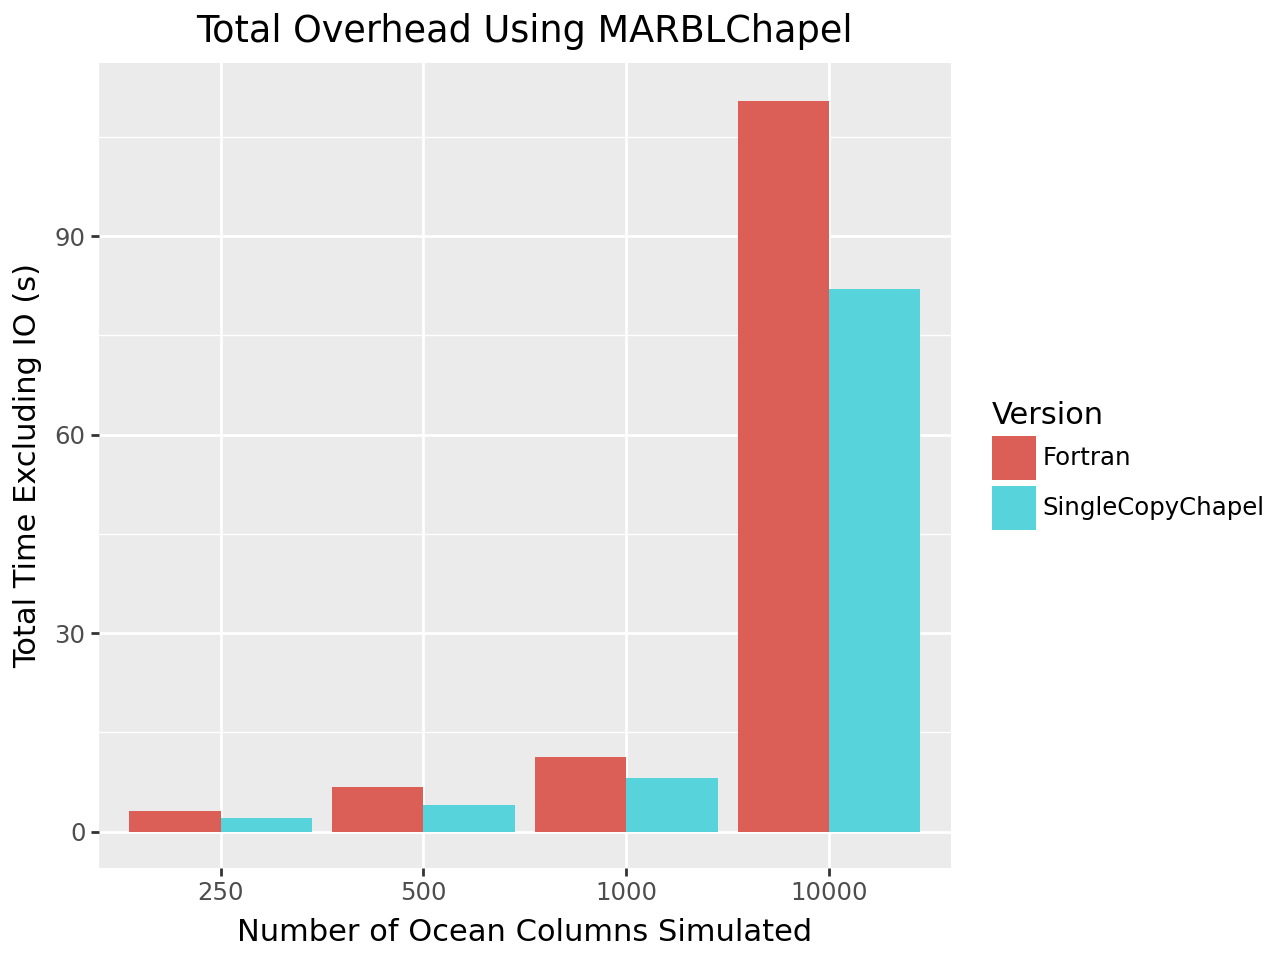

In [245]:
# Overall performance comparison
overhead_df = pd.DataFrame({'NumRuns':overheads.index, 'Label': overheads.values})
overhead_df

merged = data.copy().merge(overhead_df)
merged

merged['Label'] = merged['Label'].astype(str).str[0:5] + "%"
merged['Label'] = merged.apply(lambda row : row['Label'] if row['Version'] == 'Chapel' else None, axis=1)
p = ggplot(merged, aes(x='factor(OceanColumns)', y='Total Time (s)', fill='Version')) + geom_bar(position='dodge', stat='identity') + geom_text(aes(label='Label'), nudge_y=0.2, size=10)
p = p + labs (x='Number of Ocean Columns Simulated', y='Total Time Excluding IO (s)',title='Total Overhead Using MARBLChapel')
p 


Setup Overhead:
NumRuns
50     -32.124639
100    -39.544372
200    -28.472885
2000   -27.158190
Name: Setup Time (s), dtype: float64
Stepping Overhead:
NumRuns
50      44.892421
100     26.285366
200     14.087192
2000    68.692228
Name: Stepping Time (s), dtype: float64


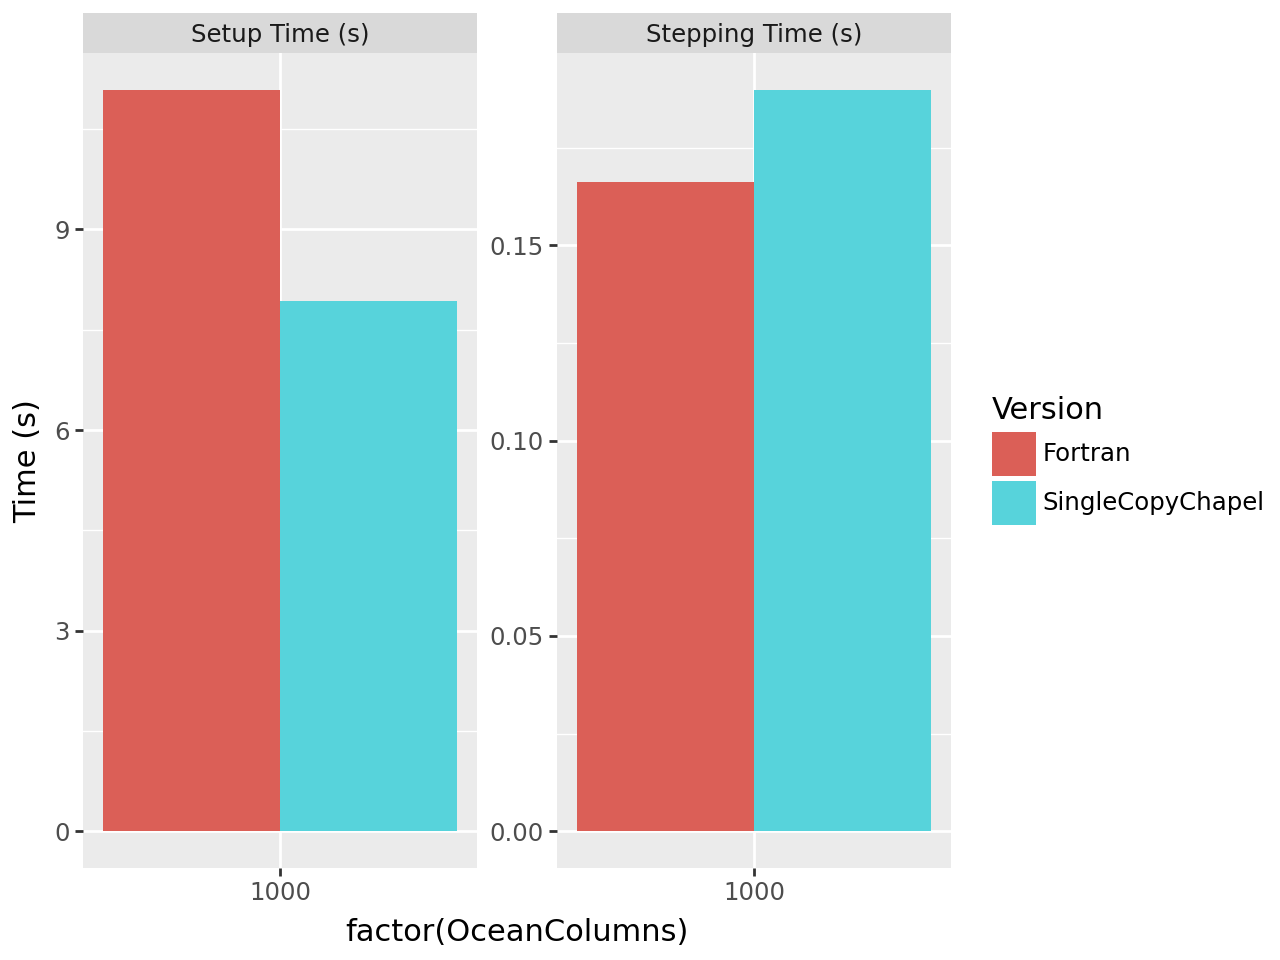

In [246]:
# split by phase type
melted = pd.melt(
  data,
    id_vars=['Version', 'NumRuns', 'OceanColumns'],
    value_vars=['Stepping Time (s)', 'Setup Time (s)'],
    var_name='PhaseType',
    value_name='Time (s)'
)
melted = melted[melted['OceanColumns'] == 1000]
p = ggplot(melted, aes(x='factor(OceanColumns)', y='Time (s)', fill='Version')) + geom_bar(position='dodge', stat='identity') 
p = p + facet_wrap('PhaseType', scales='free')


print('Setup Overhead:')
print((memcpy['Setup Time (s)'] - fortran['Setup Time (s)']) / fortran['Setup Time (s)'] * 100)
print('Stepping Overhead:')
print((memcpy['Stepping Time (s)'] - fortran['Stepping Time (s)']) / fortran['Stepping Time (s)'] * 100)
p

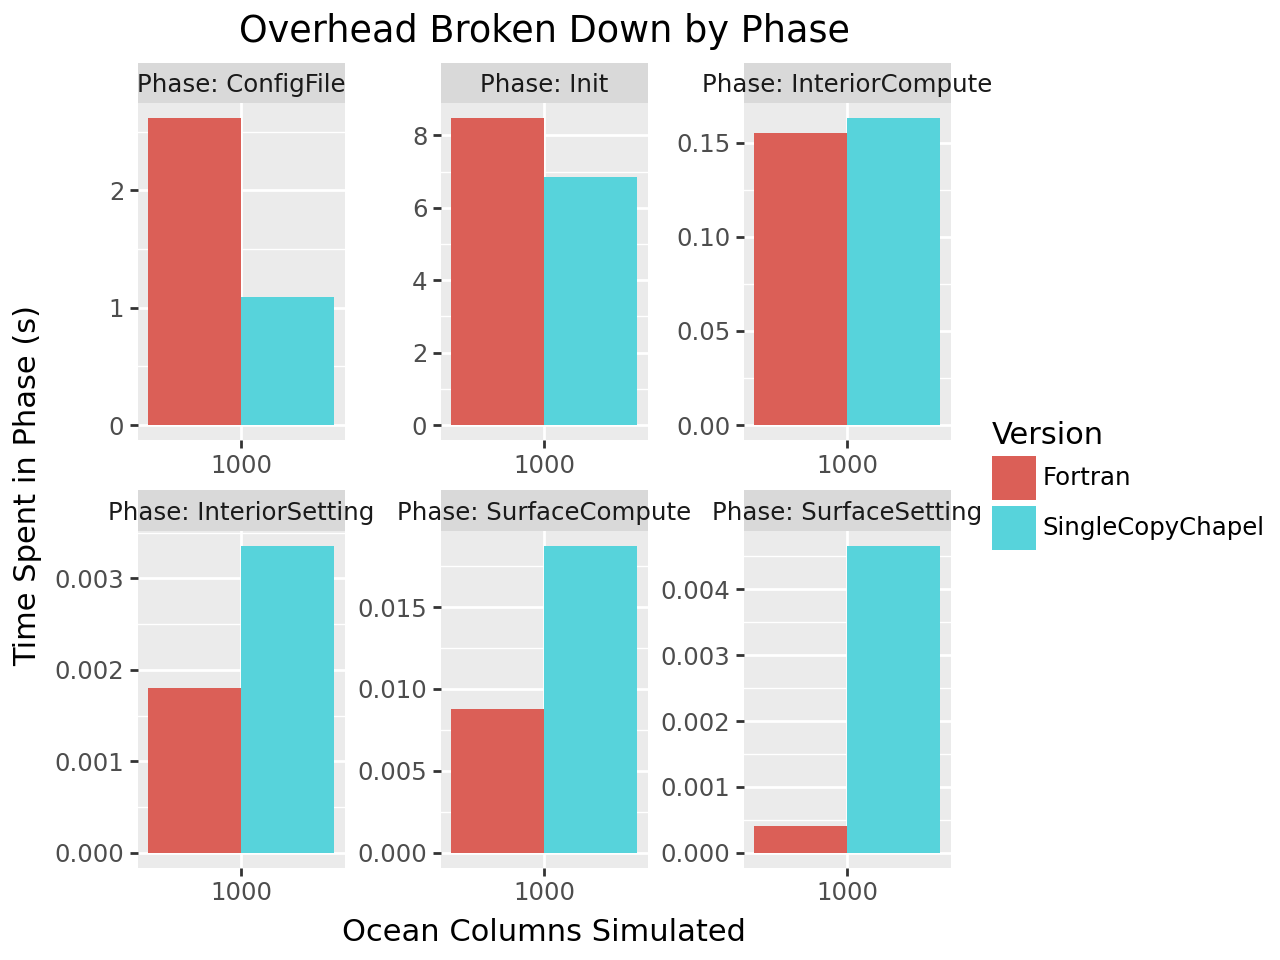

In [ ]:
melted = pd.melt(
    data,
    id_vars=['Version', 'NumRuns', 'OceanColumns'],
    value_vars=total_columns,
    var_name='Phase',
    value_name='Time'
)
melted
melted = melted[melted['NumRuns'] == 2000]
p = ggplot(melted, aes(x='factor(OceanColumns)', y='Time', fill='Version')) + geom_bar(stat='identity',position='dodge') + facet_wrap('Phase',scales='free' ,labeller='label_both')
p = p + labs(x='Ocean Columns Simulated', y='Time Spent in Phase (s)', title='Overhead Broken Down by Phase')
p

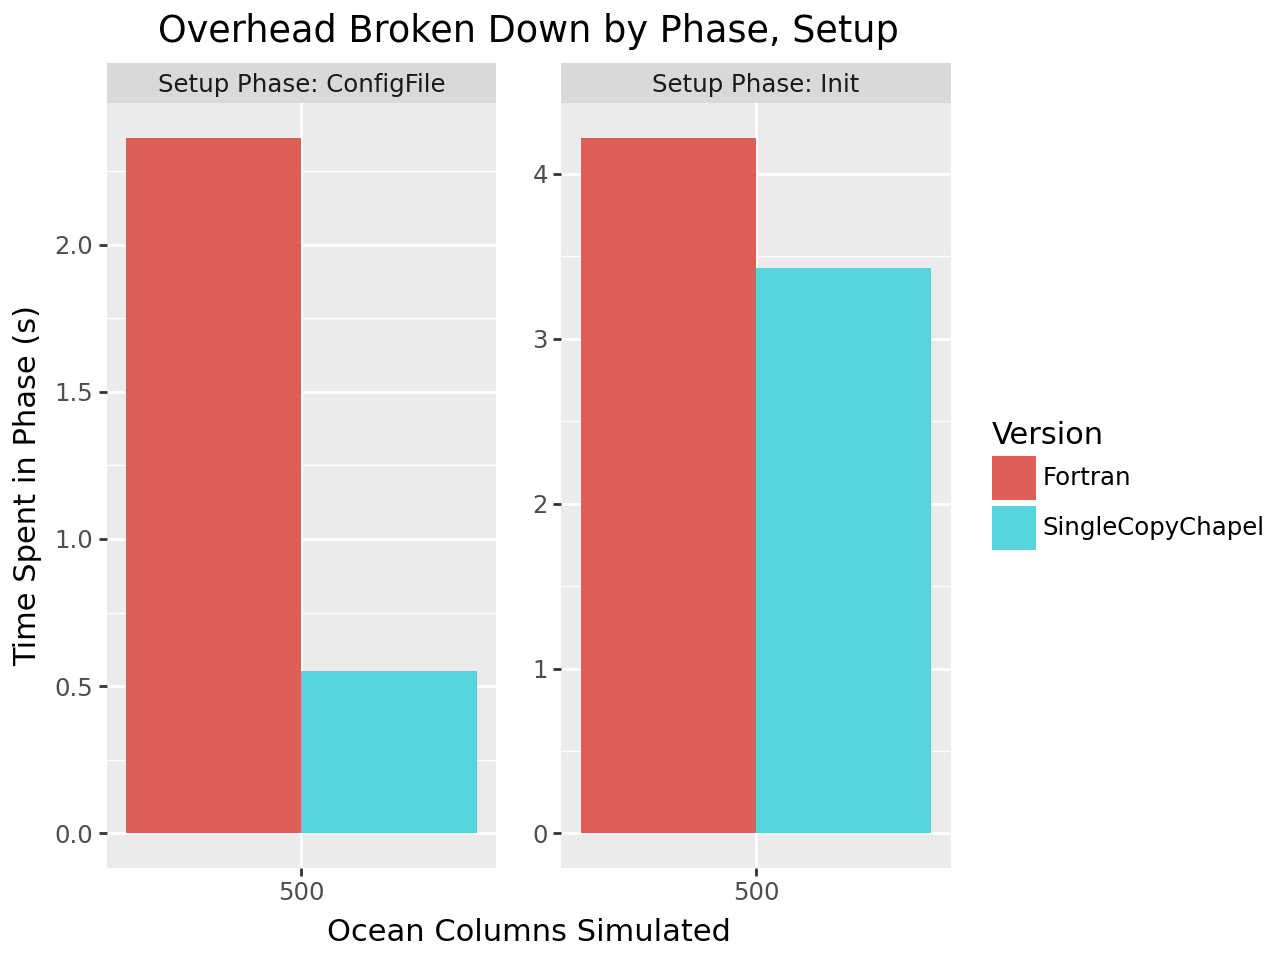

In [248]:
# Break down the overhead by its phase type. Starting with setup
melted = pd.melt(
    data,
    id_vars=['Version', 'NumRuns', 'OceanColumns'],
    value_vars=setup_columns,
    var_name='Setup Phase',
    value_name='Time'
)
melted

melted = melted[melted['NumRuns'] == 100]
p = ggplot(melted, aes(x='factor(OceanColumns)', y='Time', fill='Version')) + geom_bar(stat='identity',position='dodge') + facet_wrap('Setup Phase',scales='free' ,labeller='label_both')
p = p + labs(x='Ocean Columns Simulated', y='Time Spent in Phase (s)', title='Overhead Broken Down by Phase, Setup')
p

/global/homes/n/neth/.local/lib/python3.11/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_bar : Removed 1 rows containing missing values.


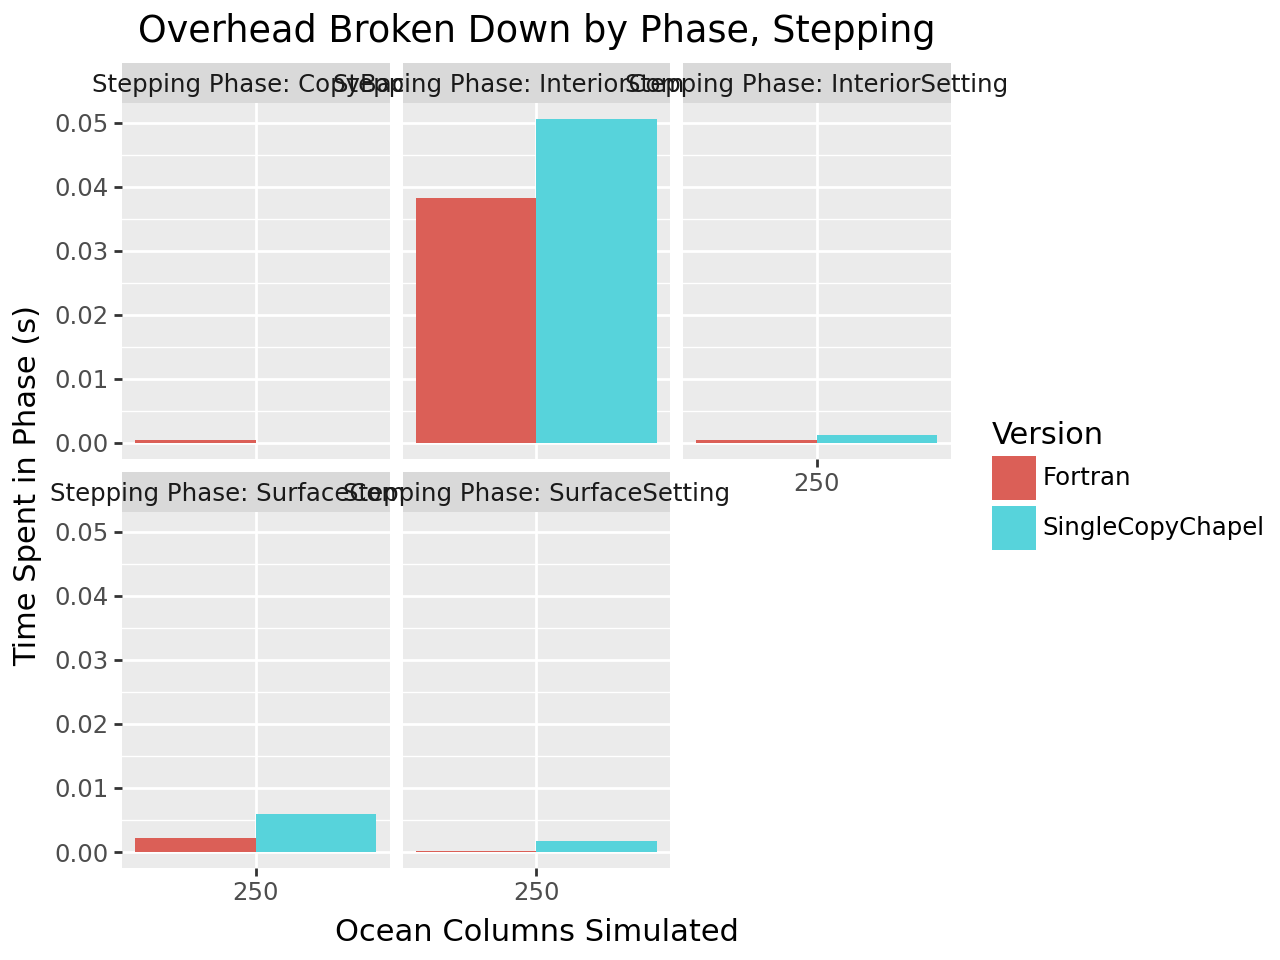

In [249]:
# Same for stepping
melted = pd.melt(
    data,
    id_vars=['Version', 'NumRuns', 'OceanColumns'],
    value_vars=stepping_columns,
    var_name='Stepping Phase',
    value_name='Time'
)

melted
melted = melted[melted['NumRuns'] == 50]
stepping_data=melted
p = ggplot(melted, aes(x='factor(OceanColumns)', y='Time', fill='Version')) + geom_bar(stat='identity',position='dodge') + facet_wrap('Stepping Phase' ,labeller='label_both')
p = p + labs(x='Ocean Columns Simulated', y='Time Spent in Phase (s)', title='Overhead Broken Down by Phase, Stepping')
p

In [250]:
# Single-step time for Michelle's question

stepping_data
fstep_time = stepping_data[stepping_data['Version'] == 'Fortran']['Time'].sum() / 500
cstep_time = stepping_data[stepping_data['Version'] == 'Chapel']['Time'].sum() / 500

print(fstep_time, cstep_time)
print(1/fstep_time, 1/cstep_time)

8.28e-05 0.0
12077.294685990339 inf


/tmp/ipykernel_1729762/1113100140.py:8: RuntimeWarning: divide by zero encountered in scalar divide


In [251]:
# Now need to make the scaling plots
weak_data = pd.read_csv('weak-scaling.csv')
strong_data = pd.read_csv('strong-scaling.csv')

strong_data['TotalColumns'] = strong_data['NodeCount'] * strong_data['RunsPerNode'] * 5

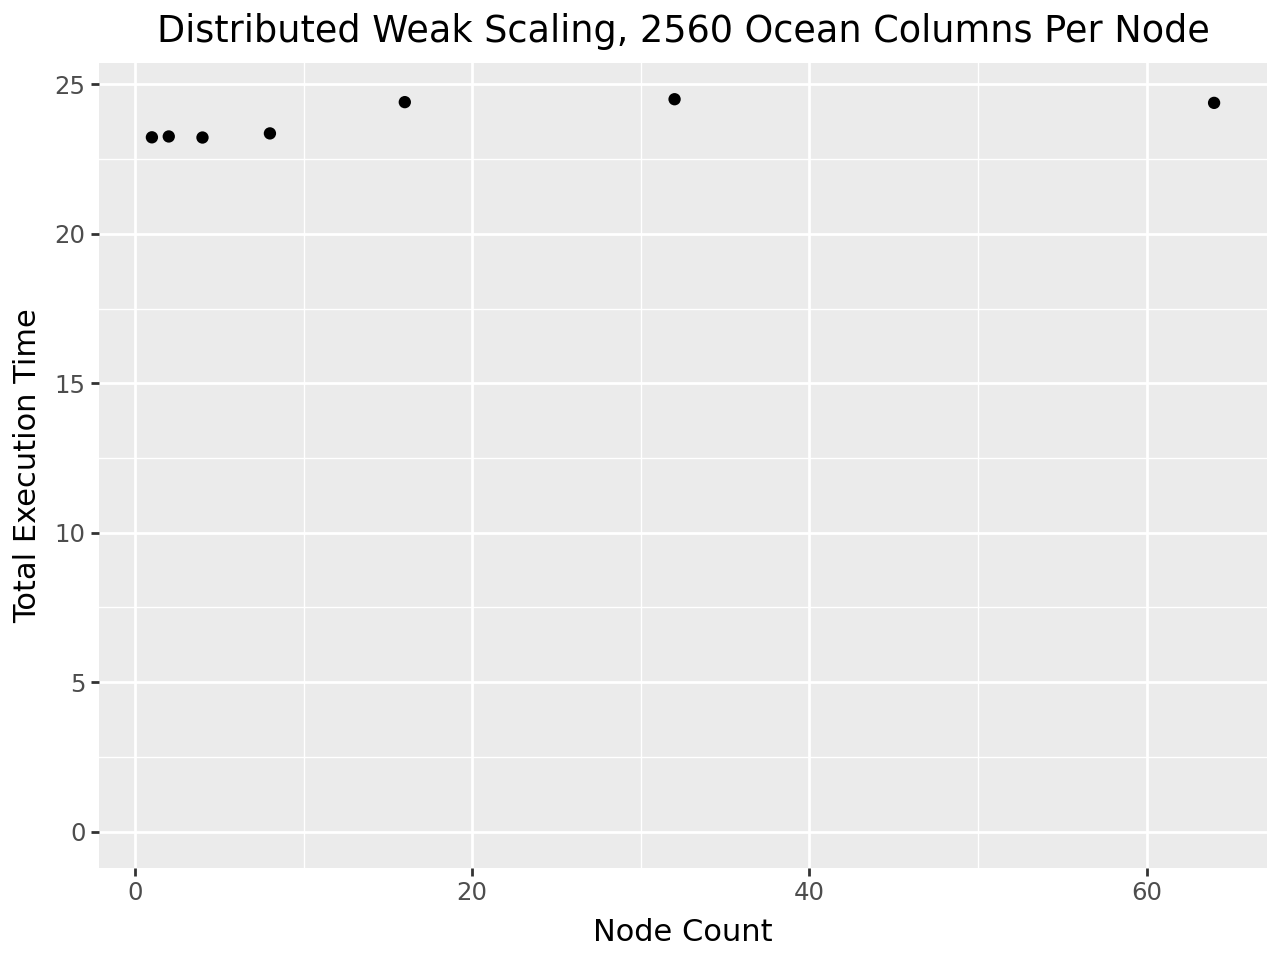

In [252]:
# Weak scaling plot
p = ggplot(weak_data, aes(x='NodeCount', y='Time')) + geom_point()
p = p + labs(x="Node Count", y='Total Execution Time', title="Distributed Weak Scaling, 2560 Ocean Columns Per Node")
p = p + scale_y_continuous(limits=(0,None))
p

    NodeCount  Series  Total Execution Time
0           1   Ideal             22.924800
1           2   Ideal             11.462400
2           4   Ideal              5.731200
3           8   Ideal              2.865600
4          16   Ideal              1.432800
5          32   Ideal              0.716400
6          64   Ideal              0.358200
7           1  Actual             22.924800
8           2  Actual             11.632400
9           4  Actual              5.906830
10          8  Actual              2.997890
11         16  Actual              1.552890
12         32  Actual              0.842186
13         64  Actual              0.474653


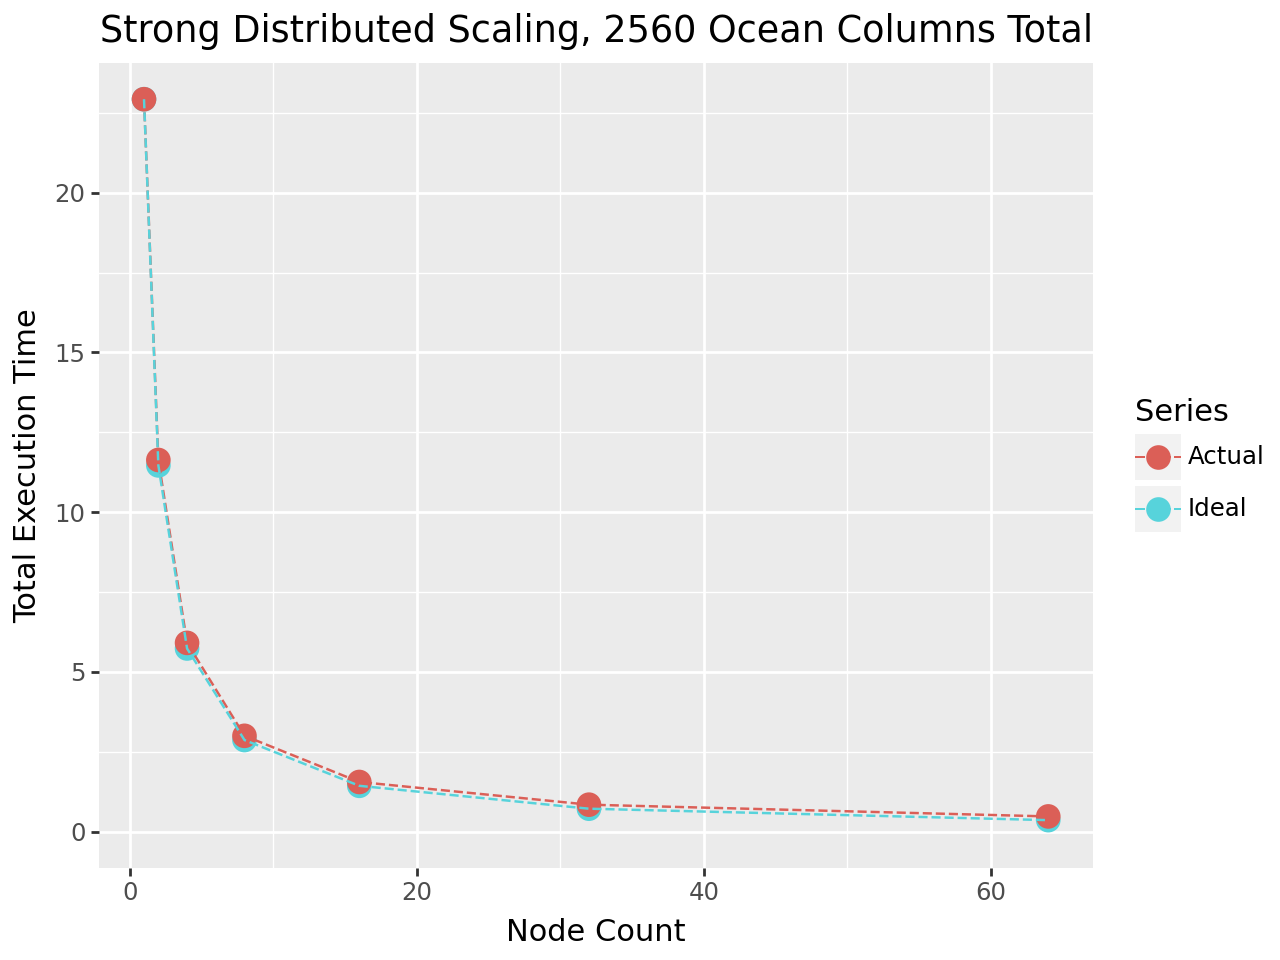

In [253]:
# Strong Scaling plots

one_node_time = strong_data[strong_data['NodeCount'] == 1]['Time'].values[0]

strong_data['Ideal'] = one_node_time / strong_data['NodeCount']

melted = pd.melt(strong_data, id_vars=['NodeCount'], value_vars=['Ideal', 'Time'], var_name='Series', value_name='Total Execution Time')
melted['Series'] = melted['Series'].str.replace('Time', 'Actual')

print(melted)
p = ggplot(melted, aes(x='NodeCount', y='Total Execution Time', color='Series')) + geom_point(size=4)
p = p + geom_line(linetype='dashed')
p = p + labs(x='Node Count', y='Total Execution Time', title='Strong Distributed Scaling, 2560 Ocean Columns Total')
p = p + scale_y_continuous(limits=(0,None))
p